### Imports

In [129]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt

In [130]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f4]
dfs = [df1, df4]
Hfs = [Hf1, Hf4]
fnames = ["f1", "f4"]

In [131]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
    return alpha

In [132]:
def newtons_method(x0, f, grad_f, hessian_f, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    """
    Implements Newton's Method with a modified Hessian when necessary.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        hessian_f: Hessian (second derivative) of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x = x0
    xs = [x0]
    
    for _ in range(max_iters):
        grad = grad_f(x)
        hessian = hessian_f(x)
        
        if np.linalg.norm(grad) < tol:
            break 
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            p = -np.linalg.solve(hessian, grad)
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            H = sum((1 / abs(eigval)) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs))
            p = -H @ grad
        
        alpha = backtracking_line_search(f, grad_f, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    
    return x, xs

In [133]:
def steepest_descent(x0, f, df, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    """
    Implements the Steepest Descent Algorithm with Backtracking Line Search.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x=x0
    beta = 1.0
    xs = [x0]
    
    for _ in range(max_iters):
        pk = -df(x)
        if np.linalg.norm(pk) < tol:
            break
        
        alpha = backtracking_line_search(f, df, x, pk, beta, c1, rho)
        x = x + alpha * pk
        beta = alpha / rho
        xs.append(x)
    
    return x, xs


### Conjugate Gradients

In [134]:
#Max iter afhænger nok af newton som kalder CG, måske skal det hedde noget andet
def conjugate_gradients(Q, g, eps, max_iter=1000):
    x = 0
    grad = g
    p = -grad
    counter = 0
    for i in range(max_iter):
        Qp = np.dot(Q, p)
        alpha_k = -(np.dot(p, grad) / np.dot(p, Qp))

        x = x + alpha_k * p
        
        grad = np.dot(Q, x) + g
        
        if np.linalg.norm(grad) < eps:
            break

        p = -grad + (np.dot(grad, Qp) / np.dot(p, Qp)) * p
        grad = grad
        counter += 1
    return x, counter

### Approximate Newton

In [135]:
def approximate_newton(x, f, df, hf, c1=1e-4, rho=0.9, max_iter=1000, tol=1e-6):
    xs = [x]
    cg_count_per_iter = []
    for i in range(max_iter):

        if np.linalg.norm(df(x)) < tol:
            cg_count_per_iter.append(0)
            break 
        
        n_k = 0.5 * min(0.5, np.sqrt(np.linalg.norm(df(x))))
        eps = n_k * np.linalg.norm(df(x))
        p, counter = conjugate_gradients(hf(x), df(x), eps)
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)

        cg_count_per_iter.append(counter)
    return x, xs, cg_count_per_iter

### Benchmarking

In [136]:
def benchmark(f, df, optimizer, x0, x_opt, Hf=None):
    start_time = time.time()
    if optimizer == steepest_descent:
        x_final, xs = optimizer(x0, f, df)
    if optimizer == newtons_method:
        x_final, xs = optimizer(x0, f, df, Hf)
    if optimizer == approximate_newton:
        x_final, xs, cg_count_per_iter = optimizer(x0, f, df, Hf)
    # steepest skal ikke have HF
    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]
    if optimizer == approximate_newton:
        return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, grad_norms[-1], cg_count_per_iter)

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, grad_norms[-1])


In [137]:
SEED = 10
np.random.seed(SEED)

d = 20
num_runs = 50

benchmark_results = []


for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, d)
    #Approx Newtons Method
    for _ in range(num_runs):
        x0 = np.random.randn(d)        
        sd_result = benchmark(f, df, approximate_newton, x0, x_optimal, Hf)
        benchmark_results.append((fname, "Approximate Newton") + sd_result)

    #Original Newtons Method
    for _ in range(num_runs):
        x0 = np.random.randn(d)  
        sd_result = benchmark(f, df, newtons_method, x0, x_optimal, Hf)
        benchmark_results.append((fname, "Newtons Method") + sd_result)

    #Steepest Descent 
    for _ in range(num_runs):
        x0 = np.random.randn(d)
        sd_result = benchmark(f, df, steepest_descent, x0, x_optimal, Hf)
        benchmark_results.append((fname, "Steepest Descent") + sd_result)
# Convert to DataFrame
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms", "Final Gradient Norm", "CG iterations per Newton iteration"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_display = df_results.drop(columns=["Final Solution Point", "Gradient Norms", "CG iterations per Newton iteration"])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=df_display)

Benchmark Results


In [138]:
df_avg_results = df_results.groupby(["Function", "Optimizer"]).agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final Function Value": "mean",
    "Distance to Optimum": "mean",
    "Final Gradient Norm": "mean"
}).reset_index()

# Display the final averaged results
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

Averaged Optimization Results


In [139]:
def extract_grad_norms(df, function_name, optimizer_name):
    return df[(df["Function"] == function_name) &  (df["Optimizer"] == optimizer_name)]["Gradient Norms"].tolist()


def pad_grad_norms(grad_norms_list):
    max_length_run = max(len(run) for run in grad_norms_list)
    #print(max_length_run)
    padded_runs = []

    for run in grad_norms_list:
        padded_run = np.pad(run, (0, max_length_run - len(run)), mode="constant", constant_values=0)
        padded_runs.append(padded_run)
    
    return padded_runs

def get_avg_grad_norms(df, function_name, optimizer_name):

    grad_norms = extract_grad_norms(df, function_name, optimizer_name)
    padded_grad_norms = pad_grad_norms(grad_norms)
    mean_grad_norms = np.mean(padded_grad_norms, axis=0)

    return mean_grad_norms

In [140]:
f1_newton_avg = get_avg_grad_norms(df_results, "f1", "Newtons Method")
f4_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")

f1_sd_avg = get_avg_grad_norms(df_results, "f1", "Steepest Descent")
f4_sd_avg = get_avg_grad_norms(df_results, "f4", "Steepest Descent")

f1_appnewton_avg = get_avg_grad_norms(df_results, "f1", "Approximate Newton")
f4_appnewton_avg = get_avg_grad_norms(df_results, "f4", "Approximate Newton")

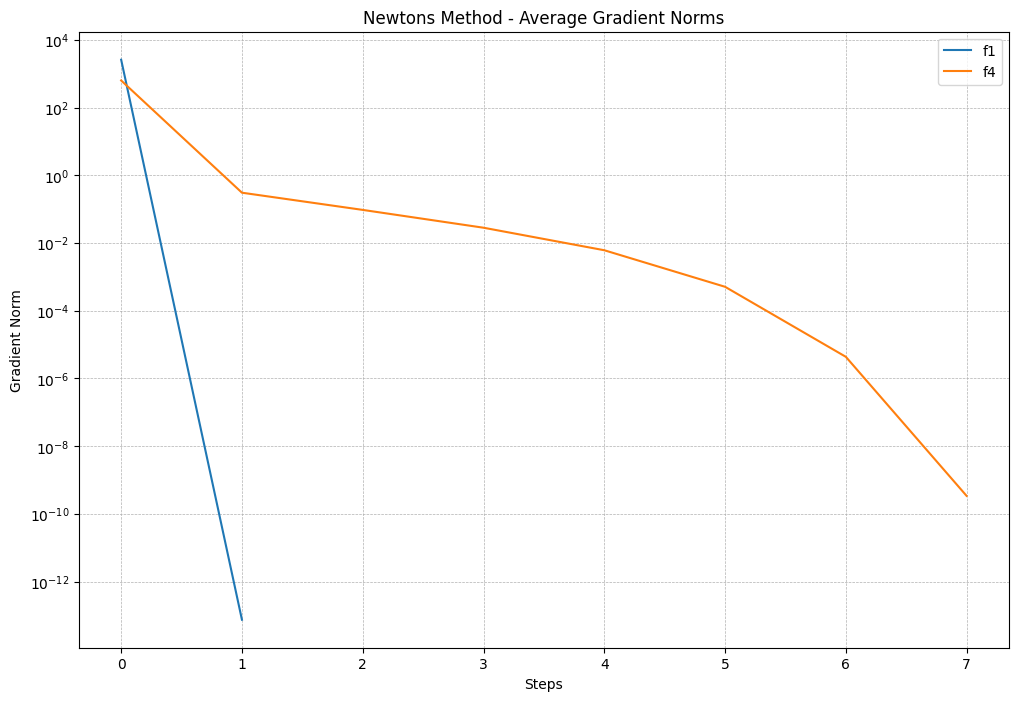

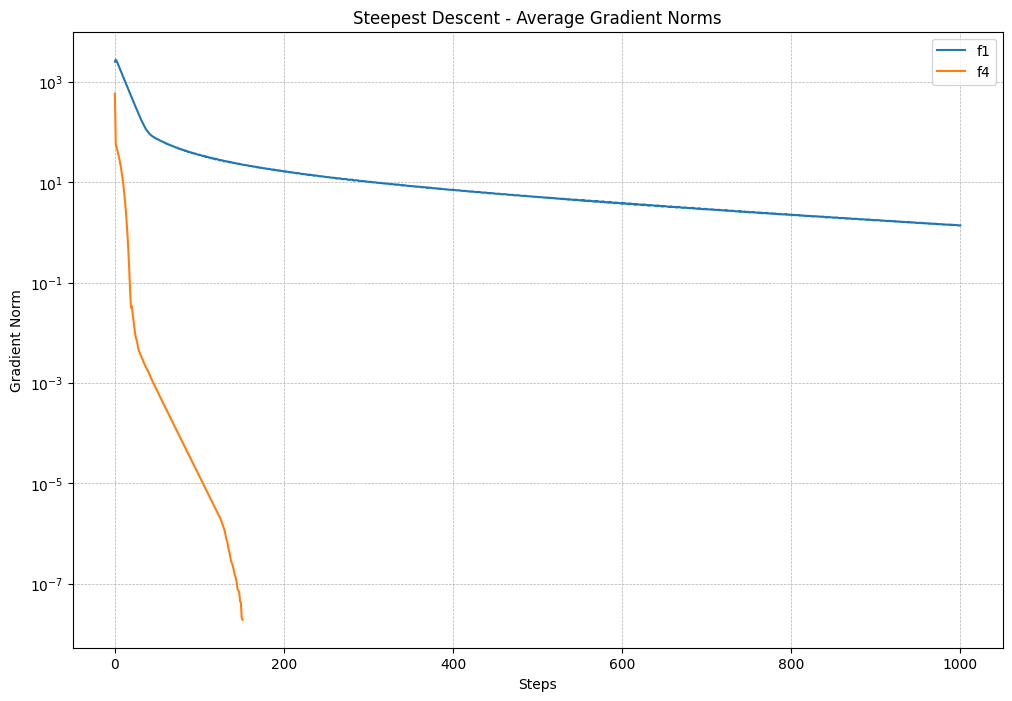

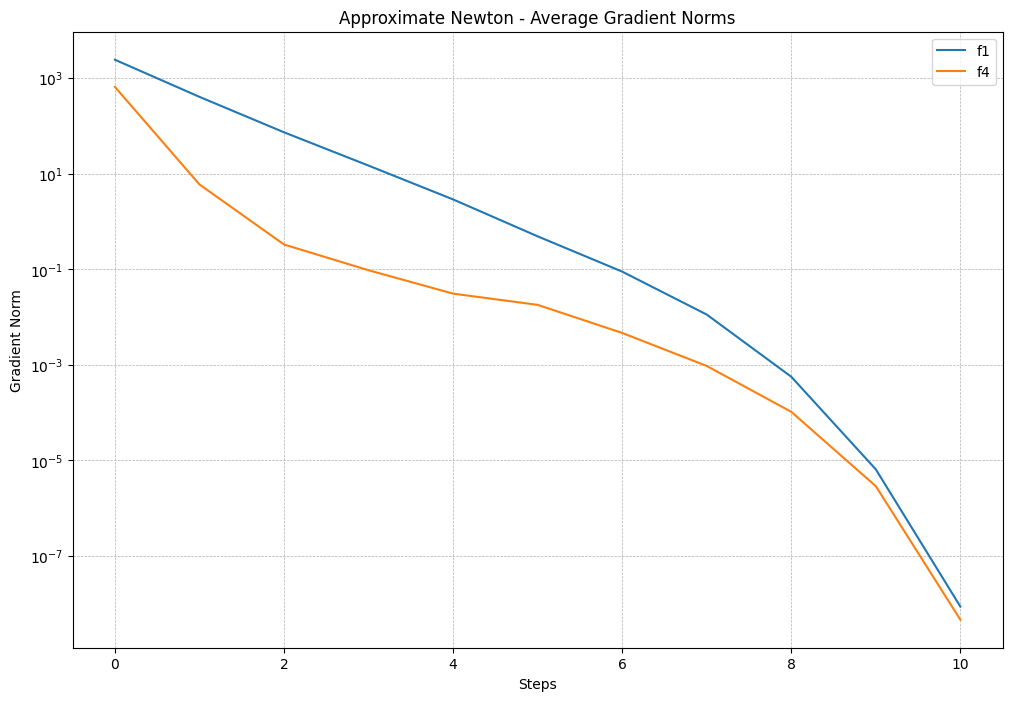

In [141]:
def plot_convergence(title, f1_avg, f4_avg):
    plt.figure(figsize=(12, 8))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")

    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

plot_convergence("Newtons Method - Average Gradient Norms", f1_newton_avg, f4_newton_avg)
plot_convergence("Steepest Descent - Average Gradient Norms", f1_sd_avg, f4_sd_avg)
plot_convergence("Approximate Newton - Average Gradient Norms", f1_appnewton_avg, f4_appnewton_avg)


### Plotting

In [142]:
def get_avg_cg_iterations(df, function_name):
    cg_iterations = df[(df["Function"] == function_name) &  (df["Optimizer"] == "Approximate Newton")]["CG iterations per Newton iteration"].tolist()
    
    max_newton_steps = max(len(run) for run in cg_iterations)

    padded_cg_iterations = []
    for run in cg_iterations:
        padded_run = np.pad(run, (0, max_newton_steps - len(run)), mode="constant", constant_values=0)
        padded_cg_iterations.append(padded_run)

    avg_cg_iterations = np.mean(padded_cg_iterations, axis=0)

    return avg_cg_iterations

In [143]:
avg_cg_iters_f1 = get_avg_cg_iterations(df_results, "f1")
avg_cg_iters_f4 = get_avg_cg_iterations(df_results, "f4")

In [144]:
def plot_avg_cg_iters_pr_newtonstep(title, cg_avg, function_name):
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(cg_avg)), cg_avg, label=function_name)
    plt.xlabel("Newton Steps")
    plt.ylabel("Average CG Iterations pr Newton Step")
    plt.title(title + " - " + function_name)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

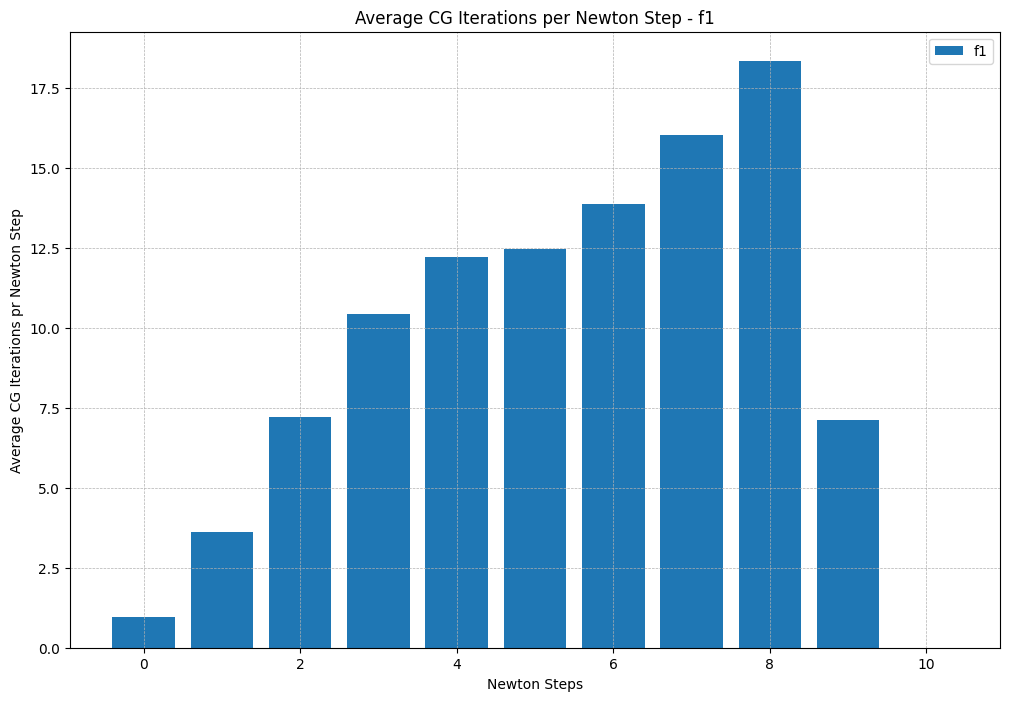

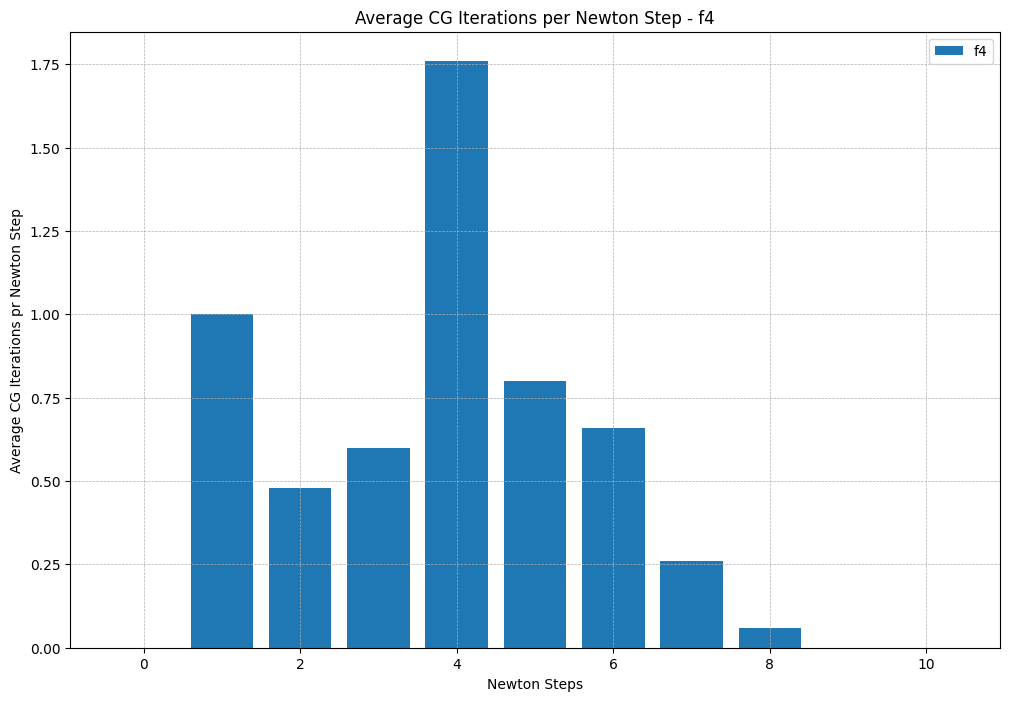

In [145]:
plot_avg_cg_iters_pr_newtonstep("Average CG Iterations per Newton Step", avg_cg_iters_f1, "f1")
plot_avg_cg_iters_pr_newtonstep("Average CG Iterations per Newton Step", avg_cg_iters_f4, "f4")

2.9106919845550118e-08
7.558620619315931e-10


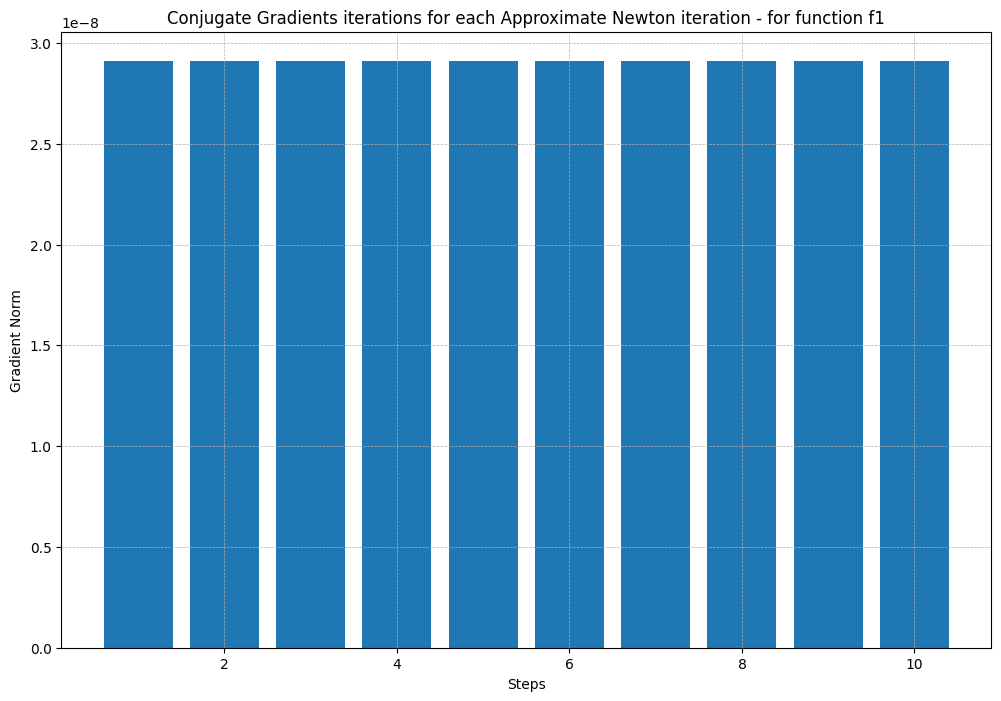

In [146]:
print(df_results.iloc[0,8])
print(df_results.iloc[1,8])
plt.figure(figsize=(12, 8))
plt.bar(range(1 ,df_results.iloc[0,2]+1), df_results.iloc[0,8])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title(f"Conjugate Gradients iterations for each Approximate Newton iteration - for function {df_results.iloc[0,0]}")
# plt.yscale("log")
# plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

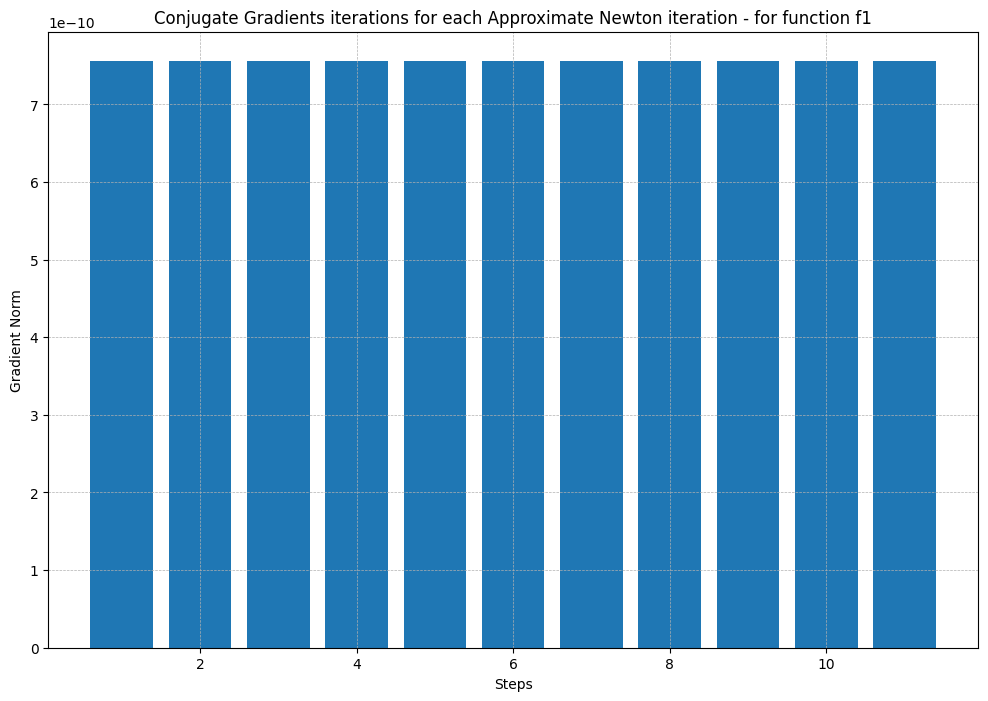

In [147]:
# print(df_results.iloc[0,8])
# print(df_results.iloc[1,8])
plt.figure(figsize=(12, 8))
plt.bar(range(1 ,df_results.iloc[1,2]+1), df_results.iloc[1,8])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title(f"Conjugate Gradients iterations for each Approximate Newton iteration - for function {df_results.iloc[1,0]}")
# plt.yscale("log")
# plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Approximate Newton
Approximate Newton


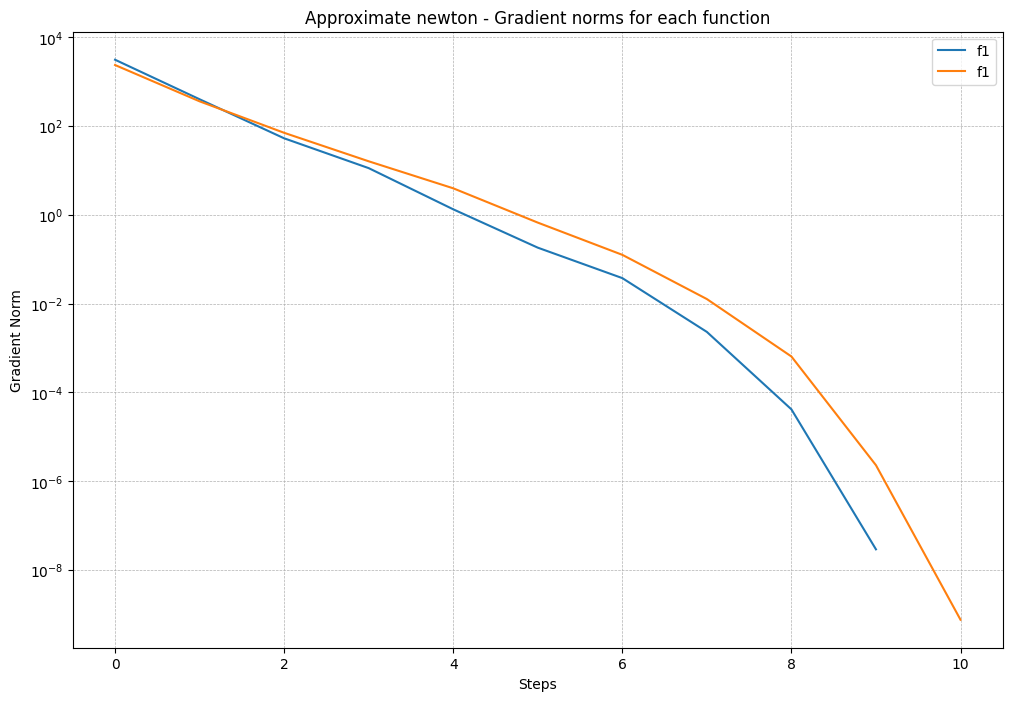

In [148]:
plt.figure(figsize=(12, 8))
for i in range(2):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Approximate newton - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Approximate Newton
Approximate Newton


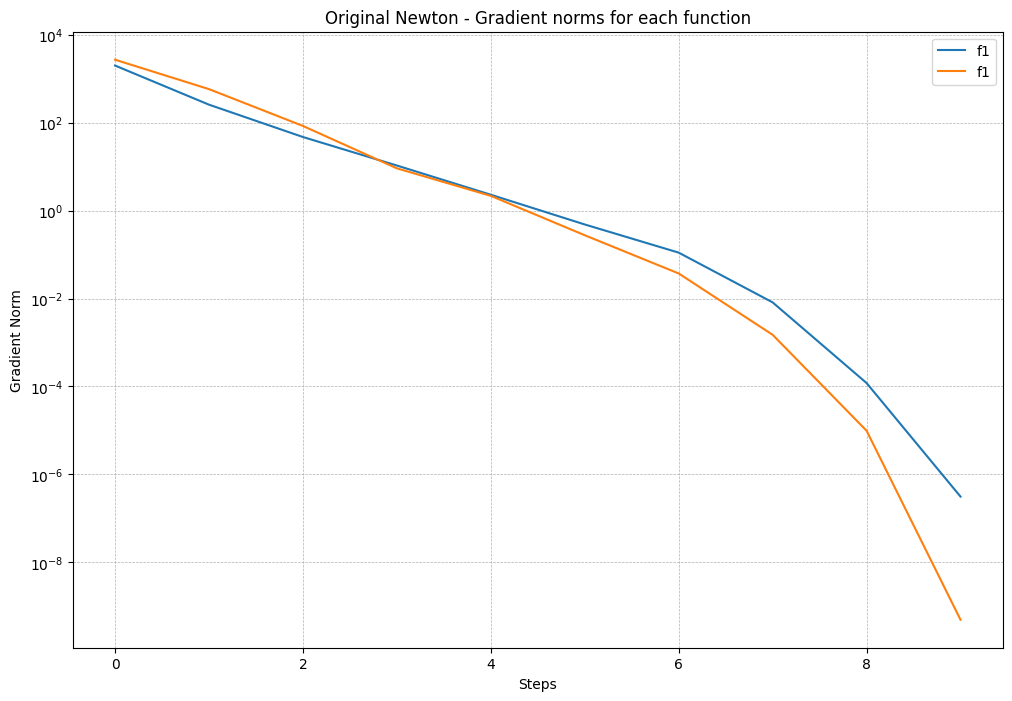

In [149]:
plt.figure(figsize=(12, 8))
for i in range(2,4):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Original Newton - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Approximate Newton
Approximate Newton


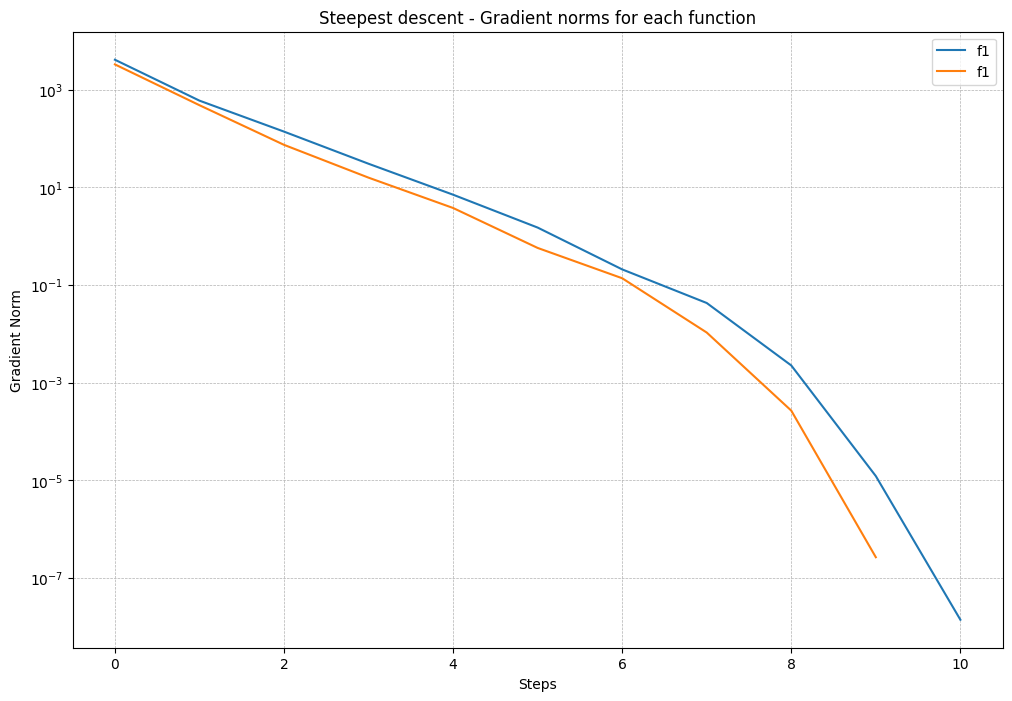

In [150]:
plt.figure(figsize=(12, 8))
for i in range(4,6):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Steepest descent - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()